# 3. Polynomial Regression and Overfitting/Underfitting

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (23/01/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Mock dataset generation

This will be different compared than what has been implemented in notebooks 1 and 2, as we will generate prices $ y_i $ as a polynomial function of the surfaces $ x_i $.

In this notebook, we will assume that the function f(x), giving the price of an appartment with surface $ x $, is defined as a polynomial function with degree 3.

$$ f(x) = 100000 + 14373x + 3x^3. $$

In addition, we will add a random noise to the final pricing, with a $ +/- 10\% $ drift as before.

In [3]:
# All helper functions
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this has changed and is now a polynomial function.
    return round((100000 + 14373*surface + 3*surface**3)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def generate_datasets(n_points, min_surf, max_surf):
    x = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    y = np.array([price(i) for i in x])
    return x, y
def linreg_matplotlib(a, b, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = a*x + b
    return x, y
def loss_mse(a, b, x, y):
    val =  np.sum((y - (a*x + b))**2)/x.shape[0]
    return '{:.2e}'.format(val)

In [4]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
min_surf = 40
max_surf = 150
np.random.seed(47)
n_points = 500
inputs, outputs = generate_datasets(n_points, min_surf, max_surf)
print(inputs)
print(outputs)

[ 52.48 147.19 120.16  78.66 117.84 127.96 111.01  85.61 117.66  67.13
  68.16  42.64  50.86  73.05 110.49  75.44  60.4  140.89  69.8   70.09
 144.99  53.98 122.2   40.58 134.25 116.56 100.83 142.88  96.39  59.54
  99.06  72.28  41.17 137.22 112.21 143.65 121.94  69.39  79.8   97.9
 100.16  68.45  59.21  79.68  55.42  82.8   91.91 146.57  56.01  96.57
  98.04  73.58  57.56 105.66  51.41 102.48  82.49  49.32 101.82 111.29
 112.81  60.82 144.95  46.49 136.82 126.21  67.77 141.98  88.92  81.49
 138.32 122.95 125.19 136.7   92.96  73.32  88.72  98.09 106.9   97.78
 147.58 106.22 131.88  49.39  93.71 139.03 140.88  63.86  84.07  99.97
 110.61  92.1  101.99 104.82  74.49 123.38 134.29  92.41 134.95 112.7
 100.55 127.98  74.63  44.26 128.92 127.57  70.79  90.1   83.74 144.88
  78.46  46.54  40.37 107.28  77.99  92.67 148.12  61.45  75.67 147.44
 118.27 123.01  48.77  41.69  58.53  44.24 116.81 102.13 110.71  56.65
  96.64 139.2   56.28 127.99  68.33 130.69 110.18  94.25  94.1  127.58
 128.22 

### Linear Regression

As in Notebook 2., using sklearn.

In [5]:
# Reshape inputs and outputs as a 2D np.array
sk_inputs = np.array(inputs).reshape(-1, 1)
sk_outputs = np.array(outputs)
# Creating a sklearn Linear Regressor.
# It uses the same analytical formula from earlier, i.e. W^* = (X^T X)^{-1} X^T Y.
reg = LinearRegression().fit(sk_inputs, sk_outputs)
# The coefficients for a* and b* are found using coeff_ and intercept_ respectively.
a_sk = reg.coef_[0]
b_sk = reg.intercept_
print("Value for a_star, found by sklearn: ", a_sk)
print("Value for b_star, found by sklearn: ", b_sk)

Value for a_star, found by sklearn:  0.10350532787853053
Value for b_star, found by sklearn:  -4.9039975469995305


Finally, we provide a display, showing the optimal linear regression model, in magenta, below.

Unfortunately, the data does not look linear anymore (as we defined the price function as a third degree polynomial function), which is why the linear regression does not fit the data that well.

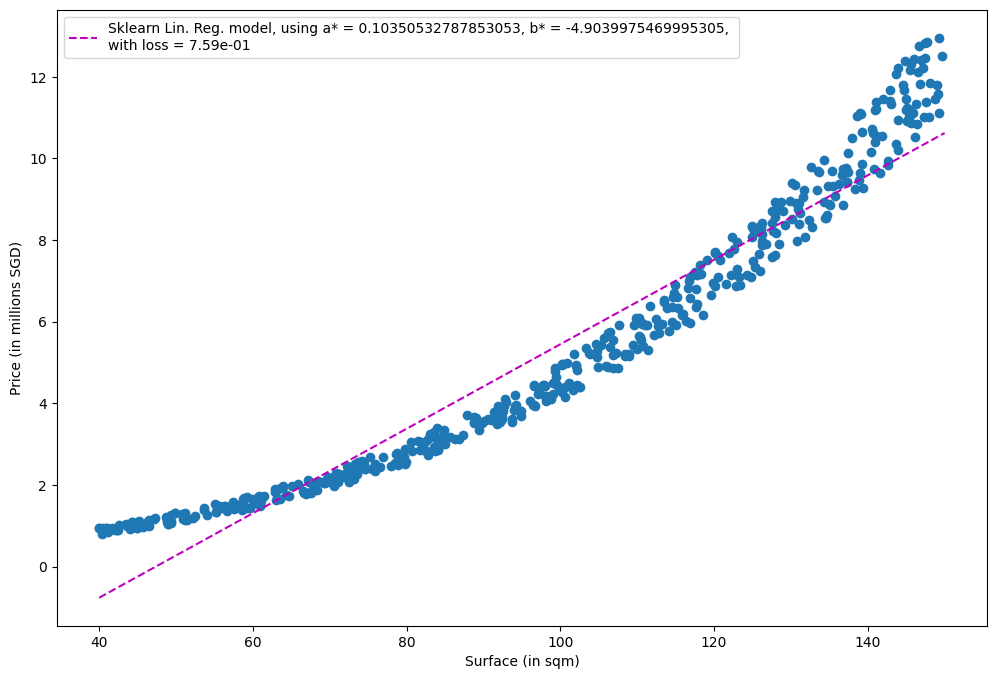

In [6]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("Surface (in sqm)")
plt.ylabel("Price (in millions SGD)")

# Optimal linreg
linreg_dataset1_inputs, linreg_dataset1_outputs = linreg_matplotlib(a_sk, b_sk, min_surf, max_surf, n_points)
loss1 = loss_mse(a_sk, b_sk, inputs, outputs)
legend1 = "Sklearn Lin. Reg. model, using a* = {}, b* = {}, \nwith loss = {}".format(a_sk, b_sk, loss1)
plt.plot(linreg_dataset1_inputs, linreg_dataset1_outputs, 'm--', label = legend1)

# Display
plt.legend(loc = 'best')
plt.show()

### Polynomial Regression

Our data is no longer linear, which is why the linear regression model is no longer good enough.

Instead, we might want to check the polynomial regression model with degree $ M $.

It works more or less the same way, in the sense we have to find some parameters $ a $ and $ b $ to fit the data, but this time $ a $ will consists of a list of $ M $ coefficients, instead of just one, i.e. $ a = (a_1, a_2, ..., a_M) $.

The assumption made by the polynomial regression model is that the outputs $ y $ can be approximated using a polynomial function of the inputs $ x $, with parameters $ a $ and $ b $ to be deciced. More specifically, the outputs and inputs are connected by:

$$ y = f(x) = \sum_{k = 1}^M a_k x^k + b .$$

Note that linear regression is therefore a special case of a polynomial regression with degree $ M $.

In order to implement the polynomial regression, we will first decide on a degree $ M $ we want to use for the polynomial function. For now, we will use the same one as our data generator, that is $ M = 3 $, we store it in **n_degree**.

Second, we will rework on our inputs, and produce polynomial features, i.e. we will rework the inputs, so that inputs are now stored in a $ N \times M $ matrix, with the columns corresponding to the inputs elevated to a given power. In other words,

$$ \forall i \in \{1, 2, ..., N\}, \forall j \in \{1, 2, ..., M\}, x_{i, j} = (x_i)^j .$$

In layman terms, if our $i$-th sample in the dataset is $ x_i = 100 $, then the $ i $-th line in our reworked inputs matrix, will look be $ [100, (100)^2 = 10000, (100)^3 = 1000000] $.

We implement this transformation, by using the **PolynomialFeatures()** function from sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), with given degree **n_degree** = 3.

We can then recognize the reworked inputs matrix, in **sk_poly_inputs**.

In [7]:
# Preparing polynomial features for our dataset
n_degree = 3
sk_poly = PolynomialFeatures(degree = n_degree, include_bias = False)
sk_poly_inputs = sk_poly.fit_transform(sk_inputs.reshape(-1, 1))
print(sk_poly_inputs)

[[5.24800000e+01 2.75415040e+03 1.44537813e+05]
 [1.47190000e+02 2.16648961e+04 3.18885606e+06]
 [1.20160000e+02 1.44384256e+04 1.73492122e+06]
 ...
 [8.38200000e+01 7.02579240e+03 5.88901919e+05]
 [4.63000000e+01 2.14369000e+03 9.92528470e+04]
 [1.32730000e+02 1.76172529e+04 2.33833798e+06]]


We then treat the polynomial regression as a linear regression with multiple inputs, each input corresponding to an $ x_i $ elevated to a given power $ j \in \{1, 2, ..., M\} $. This is simply implemented, like before with the LinearRegression() object.

The only difference, this time, is that we obtain a list of $ M = 3 $ parameters in $ a $, instead of just one, and each coefficient in the list corresponds to the $ (a_1, a_2, a_3) $ that we defined in our polynomial regression formula earlier.

In [8]:
# Training a Polynomial Regressor
poly_reg_model = LinearRegression()
poly_reg_model.fit(sk_poly_inputs, sk_outputs)
a_sk_poly = poly_reg_model.coef_
b_sk_poly = poly_reg_model.intercept_
print(a_sk_poly, b_sk_poly)

[-3.62519998e-03  2.05724652e-04  2.28063848e-06] 0.574578893096426


We earlier used the **linreg_matplotlib()** function to produce lists of values for displaying the model on matplotlib.

We now have to come up with a **polyreg_matplotlib()** function.

It basically does the same thing, but by using a polynomial function instead of a linear one. As explained in Notebook 2., we will rely on the **predict()** method, to be used on our trained polynomial regressor model.

In [9]:
# Polynomial regression of the helper function that will
# help get points for the upcoming matplotlib displays.
def polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in x])
    return x, y

In [10]:
# Mean square error as a loss function for polynomial regression
# Displaying loss using exponential notation (XXXe-YYY)
def loss_mse_poly(poly_reg_model, n_degree, inputs, outputs):
    pred = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in inputs])
    losses = (pred - outputs)**2
    val = sum(losses)/inputs.shape[0]
    return '{:.2e}'.format(val)

Just like before, we provide a display, showing the optimal linear regression model, in magenta, below. We also display the optimal polynomial regressor with degree $ M = 3 $, in dashed black. 

As before, the data does not look linear anymore (as we defined the price function as a third degree polynomial function), which is why the linear regression does not fit the data that well.

The polynomial regressor, however, manages to correctly fit the data.

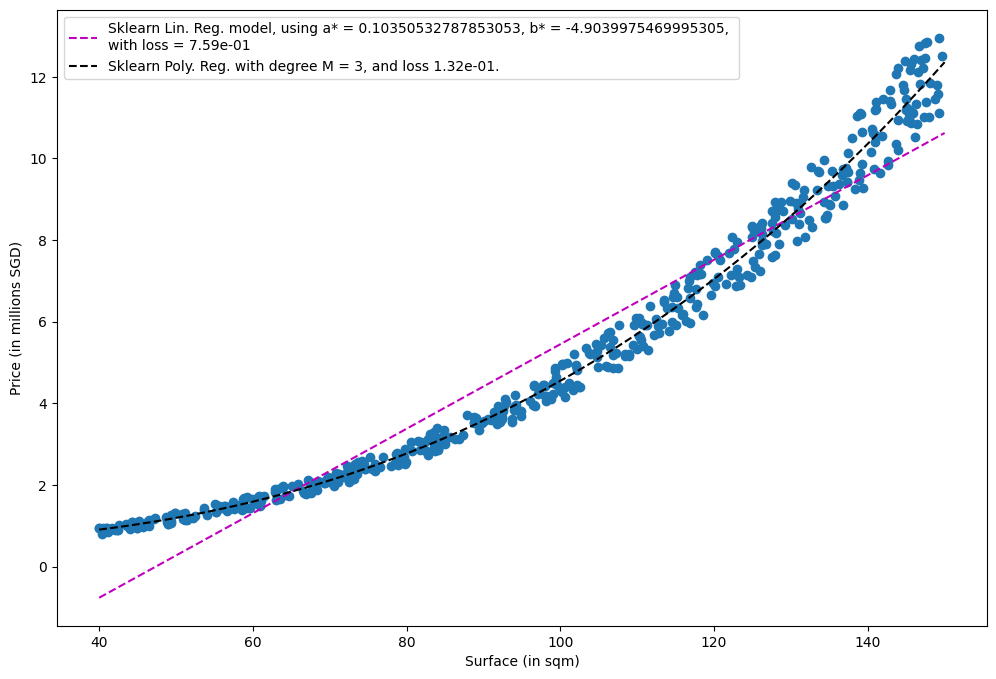

In [11]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("Surface (in sqm)")
plt.ylabel("Price (in millions SGD)")

# Optimal linreg
linreg_dataset1_inputs, linreg_dataset1_outputs = linreg_matplotlib(a_sk, b_sk, min_surf, max_surf, n_points)
loss1 = loss_mse(a_sk, b_sk, inputs, outputs)
legend1 = "Sklearn Lin. Reg. model, using a* = {}, b* = {}, \nwith loss = {}".format(a_sk, b_sk, loss1)
plt.plot(linreg_dataset1_inputs, linreg_dataset1_outputs, 'm--', label = legend1)

# Optimal poly reg (with degree M = 3)
polyreg_dataset1_inputs, polyreg_dataset1_outputs = polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points)
loss2 = loss_mse_poly(poly_reg_model, n_degree, inputs, outputs)
legend2 = "Sklearn Poly. Reg. with degree M = 3, and loss {}.".format(loss2)
plt.plot(polyreg_dataset1_inputs, polyreg_dataset1_outputs, 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

### Polynomial Regression (and why you need to avoid using too high degrees)

There is however a balance to be found when it comes to polynomial regression.

In many scenarios, it will not be possible to know in advance the degree $ M $ that was supposedly used to generate the data and connect inputs to outputs.

In those scenarios, there is no choice, but to try a few different values for $ M $ and look for the one that seems to fit the data in the best possible way.

In general, the higher the degree, the better the fit. However, using an unecessarily large polynomial degree $ M $ can lead to a very serious problem, called **overfitting**.

Let us demonstrate it, by running the polynomial regression again, with $ M = 15 $ this time (instead of $ M = 3 $ earlier).

In [11]:
# Preparing polynomial features for our dataset
n_degree2 = 12
sk_poly2 = PolynomialFeatures(degree = n_degree2, include_bias = False)
sk_poly_inputs2 = sk_poly2.fit_transform(sk_inputs.reshape(-1, 1))
# Training a Polynomial Regressor
poly_reg_model2 = LinearRegression()
poly_reg_model2.fit(sk_poly_inputs2, sk_outputs)
a_sk_poly2 = poly_reg_model2.coef_
b_sk_poly2 = poly_reg_model2.intercept_
print(a_sk_poly2, b_sk_poly2)

[ 7.76507409e-22 -1.29501383e-13  7.65768580e-18  2.43949046e-16
  1.05134577e-14  3.40320372e-13  6.39928593e-12 -2.58421501e-13
  4.26485426e-15 -3.55644988e-17  1.48863094e-19 -2.49201488e-22] 0.7607653942540518


Below, we display the curves for both polynomial regressors we have trained until now.
- In black, we display the optimal polynomial regressor with degree $ M = 3 $.
- In red, we display the optimal polynomial regressor with degree $ M = 15 $.

While both curves seem roughly similar, the red one however, seems to "glitch" when it comes to predicting prices for appartments with surfaces greater than 140 sqm.

This "glitch", is the manifestation of overfitting, which eventually will lead to poor prices estimations for appartments with surfaces greater than 140 sqm. 

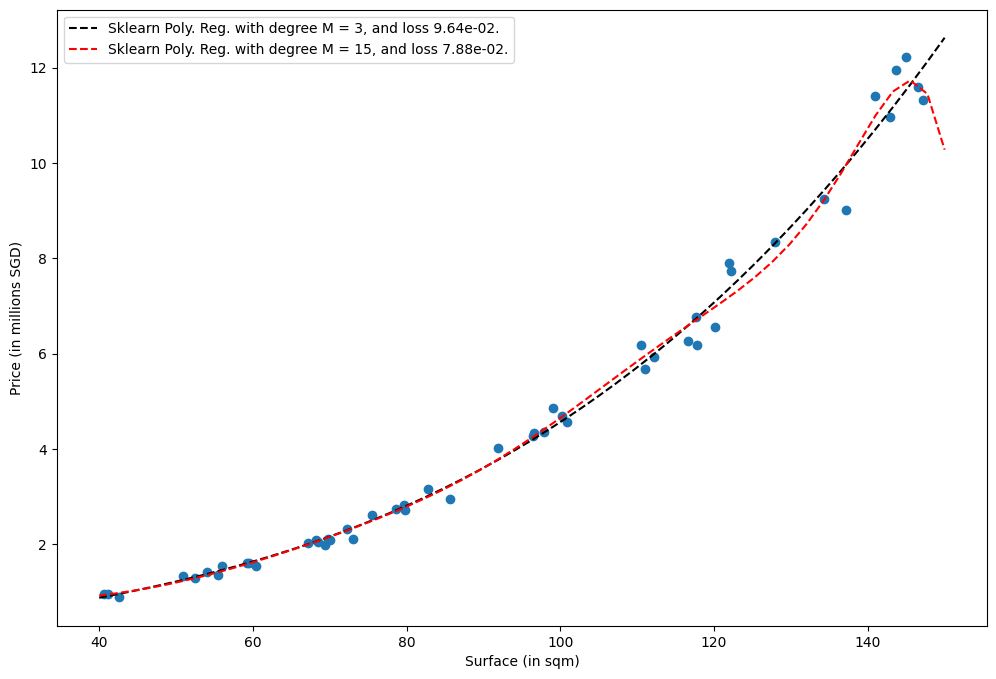

In [12]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(inputs, outputs)
plt.xlabel("Surface (in sqm)")
plt.ylabel("Price (in millions SGD)")

# Optimal poly reg (with degree M = 3)
polyreg_dataset1_inputs, polyreg_dataset1_outputs = polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points)
loss2 = loss_mse_poly(poly_reg_model, n_degree, inputs, outputs)
legend2 = "Sklearn Poly. Reg. with degree M = 3, and loss {}.".format(loss2)
plt.plot(polyreg_dataset1_inputs, polyreg_dataset1_outputs, 'k--', label = legend2)

# Optimal poly reg (with degree M = 15)
polyreg_dataset2_inputs, polyreg_dataset2_outputs = polyreg_matplotlib(poly_reg_model2, n_degree2, min_surf, max_surf, n_points)
loss3 = loss_mse_poly(poly_reg_model2, n_degree2, inputs, outputs)
legend3 = "Sklearn Poly. Reg. with degree M = 15, and loss {}.".format(loss3)
plt.plot(polyreg_dataset2_inputs, polyreg_dataset2_outputs, 'r--', label = legend3)

# Display
plt.legend(loc='best')
plt.show()

### Predicting, to confirm overfitting

In fact, we can check the performance of our two polynomial regressor models and assess overfitting, by using them to predict prices of unseen appartments.

We implement a new helper function, **theoretical_values()**, which returns the average price for an appartment with a given surface, using our pricing function from earlier, along with the lower and upper estimates (+/- 10% random variation on price we used in the mock dataset generation).

In [13]:
# Helper function for prediction evaluation
# Return interval of min and max values, along with avg value for given surface
def theoretical_values(surface):
    avg_val = round((100000 + 14373*surface + 3*surface**3))/1000000
    min_val = 0.9*avg_val
    max_val = 1.1*avg_val
    return [min_val, avg_val, max_val]

Our first polynomial regressor model (with $ M = 3 $) manages to correctly predict prices for appartments with size 95 sqm and 150 sqm.

In [14]:
new_appt_surface1 = 95
pred_price1 = poly_reg_model.predict(np.array([[(new_appt_surface1)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price1, theoretical_values(new_appt_surface1))
new_appt_surface2 = 150
pred_price2 = poly_reg_model.predict(np.array([[(new_appt_surface2)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price2, theoretical_values(new_appt_surface2))

4.058356263522412 [3.633804, 4.03756, 4.4413160000000005]
12.628475596633503 [11.142855, 12.38095, 13.619045000000002]


Our second polynomial regressor model (with $ M = 15 $) manages to correctly predict prices for appartments with size 95 sqm, but will overestimate prices for appartments with surfaces of 150 sqm.

In [15]:
new_appt_surface1 = 95
pred_price1b = poly_reg_model2.predict(np.array([[(new_appt_surface1)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price1b, theoretical_values(new_appt_surface1))
new_appt_surface2 = 150
pred_price2b = poly_reg_model2.predict(np.array([[(new_appt_surface2)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price2b, theoretical_values(new_appt_surface2))

4.09482897811698 [3.633804, 4.03756, 4.4413160000000005]
10.279521709315233 [11.142855, 12.38095, 13.619045000000002]


This is the typical manifestation of **overfitting**, something we will investigate a bit more in detail in the next notebook.

### What's next?

In the next notebook, we will discuss the train-test split method and observe the effects of overfitting on such an approach.